# Описание проекта
Задание из соревнования на платформе Kaggle [Regression with a Tabular Media Campaign Cost Dataset](https://www.kaggle.com/competitions/playground-series-s3e11/)
## Описание данных
Набор данных для этого конкурса (как обучающий, так и тестовый) был создан на основе модели глубокого обучения, обученной на наборе данных Media Campaign Cost Prediction. Распределение характеристик близко, но не точно такое же, как в оригинале.

Целевой признак `cost`.

Основная метрика качества `root mean squared log error (RMSLE)`.
## Постановка задачи
### [Шаг 1. Знакомство с данными, их изучение и предобработка](#section1)
- загрузить библиотеки и данные;
- оценить на распределение данных в таблице;
- вывод.
### [Шаг 2. Работа с моделями:](#section2)
- создание функции для расчёта RMSLE, которая будет использоваться для расчёта целевой метрики;
- создание функции, которая будет создавать сравнительную таблицу моделей;
- создание функции, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение, а так же производить оценку переобучения;
- создание предсказания модели LinearRegression;
- создание предсказания модели RandomForestRegressor;
- создание предсказания модели CatBoostRegressor;
- создание предсказания модели LGBMRegressor;
- создание предсказания модели DummyRegressor.
### [Шаг 3. Оценка качества моделей:](#section3)
- сравнение полученных метрик;
- анализ работы моделей;
- выбор лучшей модели.
### [Шаг 4. Вывод решения](#section4)


# Решение задачи
## Шаг 1. Знакомство с данными, их изучение и предобработка <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings('ignore')

RANDOM_VAL = np.random.RandomState(42)
RAND = 42

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Функция изучения данных в таблице
def research_info(data):
    rows_count, columns_count = data.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Дубликатов: {} ({:.2%})'.format(data.duplicated().sum(), data.duplicated().sum() / len(data)))
    print('Пропусков по разным признакам:')
    print('{}'.format(data.isna().sum()))
    display(data.sample(n=5))

In [4]:
research_info(train_data)

Количество стобцов: 17
Количество строк: 360336
Дубликатов: 0 (0.00%)
Пропусков по разным признакам:
id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
170939,170939,2.12,4.0,1.0,0.0,4.0,6.18,1.0,0.0,24.0,27694.0,1.0,1.0,1.0,1.0,1.0,131.75
346387,346387,5.16,3.0,3.0,0.0,3.0,9.39,1.0,1.0,30.0,34791.0,0.0,0.0,1.0,1.0,0.0,125.48
132262,132262,13.04,4.0,2.0,0.0,0.0,16.40,0.0,0.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0,109.14
201088,201088,4.62,2.0,1.0,0.0,1.0,9.02,1.0,0.0,15.0,21215.0,1.0,0.0,0.0,0.0,0.0,90.58
262510,262510,10.90,5.0,3.0,0.0,1.0,9.35,0.0,0.0,33.0,23112.0,1.0,0.0,0.0,0.0,0.0,107.20


Данные не имеют пропусков, состоят полностью из чисел и не требуют применения дополнительного кодирования.

Сравним распределение данных на обучающей и тестовой выборках.

Text(0.5, 0.98, 'Распределение данных на различных выборках')

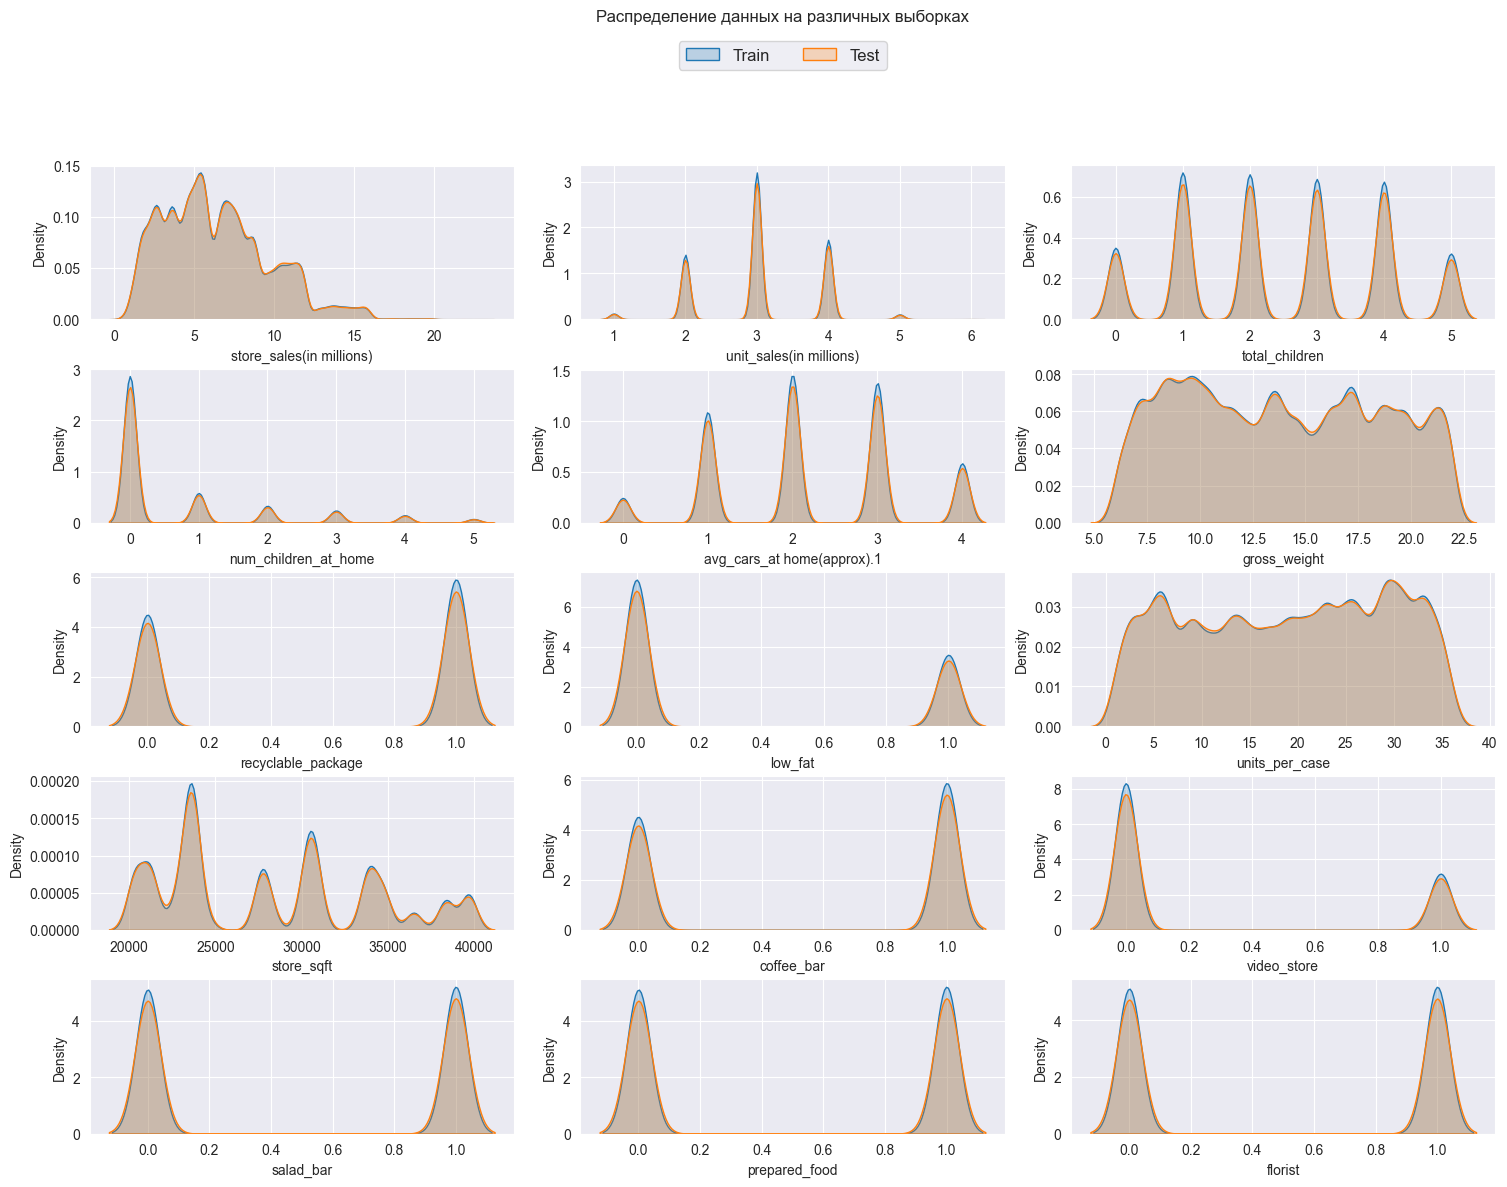

In [5]:
# Создание сетки графиков
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,12))
fig.tight_layout(pad=2)

# Освобождение места для условных обозначений
fig.subplots_adjust(top=0.85)

# Графики подсчета для оценки распределений
for i, feature in enumerate(train_data.columns[1:-1]):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.kdeplot(x=feature, data=train_data, label='Train', fill=True, ax=ax)
    sns.kdeplot(x=feature, data=test_data, label='Test', fill=True, ax=ax)

fig.legend(labels=['Train', 'Test'], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=12, ncol=3)
fig.suptitle('Распределение данных на различных выборках')

Сравнение различных функций в обучающем и тестовом наборах данных показывает идентичное распределение.

## Шаг 2. Работа с моделями <a class="anchor" id="section2"></a>

Перед обучением моделей данные необходимо поделить на обучающую, валидационную и тестовую выборки.

In [6]:
features = train_data.drop('cost', axis=1)
target = train_data['cost']

In [7]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_VAL)
features_train_, features_val, target_train_, target_val = train_test_split(features_train,
                                                                            target_train,
                                                                            test_size=0.16,
                                                                            random_state=RANDOM_VAL)
eval_set = [(features_val, target_val)]

Создадим функции, которые позволят сравнить в конце все модели и следить за качеством по ходу работы.

In [8]:
# Генерация таблицы с метриками
def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                name: str = None):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['MSLE'] = mean_squared_log_error(y_test, y_pred)
    df_metrics['RMSLE'] = np.sqrt(mean_squared_log_error(y_test, y_pred))
    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)

    return df_metrics

In [9]:
# Проверка на переобучение
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test) / mae_train * 100):.2f} %')

In [10]:
# Создание кастомной метрики RMSLE как функции потери
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = max(approxes[index], 0)
            der1 = math.log1p(targets[index]) - math.log1p(max(0, approxes[index]))
            der2 = -1 / (max(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result


class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((math.log1p(max(0, approx[i])) - math.log1p(max(0, target[i]))) ** 2)

        return error_sum, weight_sum

Выберем следующие регрессоры для обучения модели:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- RandomForestRegressor with GridSearchCV;
- LGBMRegressor;
- CatBoostRegressor;
- DummyRegressor.

В качестве метрики для всех моделей будем использовать RMSLE.

In [11]:
columns_a = list(features.columns)
columns_a.remove('id')

In [12]:
transformers_list = [('scale', StandardScaler(), columns_a)]
column_transformer = ColumnTransformer(transformers_list)

### 2.1 LinearRegression

In [13]:
lr = Pipeline([('columnTransformer', column_transformer),
               ('lr', LinearRegression())])
lr.fit(features_train, target_train)
target_pred_lr = lr.predict(features_test)

In [14]:
metrics = get_metrics(target_test, target_pred_lr, 'LinearRegression')

In [15]:
check_overfitting(lr,
                  features_train,
                  target_train,
                  features_test,
                  target_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 25.573
mean_absolute_error test: 25.602
delta = 0.11 %


### 2.2 DecisionTreeRegressor

In [16]:
parameters = {"splitter": ["best", "random"],
              "max_depth": range(1, 10, 2),
              "min_samples_leaf": range(1, 10),
              "min_weight_fraction_leaf": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              "max_features": ["auto", "log2", "sqrt", None]}

In [17]:
dt = Pipeline([('columnTransformer', column_transformer),
               ('dt', DecisionTreeRegressor(random_state=RAND))])
dt.fit(features_train, target_train)
target_pred_dt = dt.predict(features_test)

In [18]:
metrics = metrics.append(
    get_metrics(target_test, target_pred_dt, 'DecisionTreeRegressor'))

In [19]:
check_overfitting(dt,
                  features_train,
                  target_train,
                  features_val,
                  target_val,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 0.000
mean_absolute_error test: 0.000
delta = 2.64 %


### 2.3 RandomForestRegressor

In [20]:
rf = Pipeline([('columnTransformer', column_transformer),
               ('rf', RandomForestRegressor(random_state=RAND))])

rf.fit(features_train, target_train)
target_pred_rf = rf.predict(features_test)

In [21]:
metrics = metrics.append(get_metrics(target_test, target_pred_rf, 'RandomForestRegressor'))

In [22]:
check_overfitting(rf,
                  features_train,
                  target_train,
                  features_test,
                  target_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 8.981
mean_absolute_error test: 24.277
delta = 170.33 %


### 2.3.1 RandomForestRegressor with GridSearchCV

In [23]:
parameters = {'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt']}

In [24]:
rf_grid = RandomForestRegressor(random_state=RAND)
rf_grid = GridSearchCV(rf_grid,
                       cv=5,
                       scoring=make_scorer(RMSLE(), greater_is_better=False),
                       param_grid=parameters)
rf_grid.fit(features_train, target_train)
target_pred_rf_grid = rf_grid.predict(features_test)

In [25]:
metrics = metrics.append(get_metrics(target_test, target_pred_rf_grid, 'RandomForestRegressor_Grid'))

In [26]:
check_overfitting(rf_grid,
                  features_train,
                  target_train,
                  features_test,
                  target_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 8.914
mean_absolute_error test: 24.158
delta = 171.00 %


### 2.4 LGBMRegressor

In [27]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')

lgb.fit(features_train_,
        target_train_,
        eval_metric=RMSLE_val(),
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)
target_pred_lgb = lgb.predict(features_test)

In [28]:
metrics = metrics.append(get_metrics(target_test, target_pred_lgb, 'LGBMRegressor'))

In [29]:
check_overfitting(lgb,
                  features_train,
                  target_train,
                  features_test,
                  target_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 23.441
mean_absolute_error test: 23.553
delta = 0.48 %


### 2.5 CatBoostRegressor

In [30]:
cb = CatBoostRegressor(random_seed=RAND,
                       loss_function=RMSLE(),
                       eval_metric=RMSLE_val(),
                       allow_writing_files=False)

cb.fit(features_train_,
       target_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)
target_pred_cb = cb.predict(features_test)

In [31]:
metrics = metrics.append(get_metrics(target_test, target_pred_cb, 'CatBoostRegressor'))

In [32]:
check_overfitting(cb,
                  features_train,
                  target_train,
                  features_test,
                  target_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 24.809
mean_absolute_error test: 24.864
delta = 0.22 %


### 2.6 DummyRegressor

In [33]:
dr = DummyRegressor()
dr.fit(features_train, target_train)
target_pred_dr = dr.predict(features_test)

In [34]:
metrics = metrics.append(get_metrics(target_test, target_pred_dr, 'DummyRegressor'))

In [35]:
check_overfitting(dr,
                  features_train,
                  target_train,
                  features_test,
                  target_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 25.957
mean_absolute_error test: 26.014
delta = 0.22 %


**Выводы:**
- модели обучены;
- предсказания составлены;
- параметры качества моделей занесены в таблицу.

Можно обратить внимание, что в DecisionTreeRegressor очень большой показатель переобучения.

## Шаг 3. Оценка качества моделей <a class="anchor" id="section3"></a>

Выведем таблицу с метриками и выберем лучшую модель по совокупности параметров.

In [36]:
metrics

,model,MSLE,RMSLE,MAE
0,LinearRegression,0.100730,0.317379,25.601609
0,DecisionTreeRegressor,0.175264,0.418646,30.023289
0,RandomForestRegressor,0.095914,0.309700,24.277284
0,RandomForestRegressor_Grid,0.093999,0.306592,24.157861
0,LGBMRegressor,0.096391,0.310468,23.553097
0,CatBoostRegressor,0.091589,0.302637,24.863882
0,DummyRegressor,0.103017,0.320963,26.013908


- `LinearRegression` - переобучение составляет 0.11%, ключевая метрика RMSLE = 0.32;
- `DecisionTreeRegressor` - переобучение составляет 2.64%, ключевая метрика RMSLE = 0.42;
- `RandomForestRegressor` - переобучение составляет 170.33%, ключевая метрика RMSLE = 0.31;
- `RandomForestRegressor_Grid` - переобучение составляет 171.00%, ключевая метрика RMSLE = 0.31;
- `LGBMRegressor` - переобучение составляет 0.48%, ключевая метрика RMSLE = 0.31;
- `CatBoostRegressor` - переобучение составляет 0.22%, ключевая метрика RMSLE = 0.30;
- `DummyRegressor` - переобучение составляет 0.22%, ключевая метрика RMSLE = 0.32.

Исходя из полученных значений ключевой метрики, а так же из показателя переобучения можно сделать вывод, что лучше всего выдает предсказания, а значит и рекомендуется к дальнейшему использованию, модель `CatBoostRegressor`. 

## Шаг 4. Вывод решения

In [38]:
best_model = cb
best_model.fit(features, target)
predictions = best_model.predict(test_data)
predictions = pd.DataFrame(predictions, columns=['cost'])
sub = pd.concat([test_data.id, predictions], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv(f"submission5.csv")

0:	learn: 4.4463760	total: 1.35s	remaining: 22m 25s
1:	learn: 4.3218152	total: 2.99s	remaining: 24m 51s
2:	learn: 4.2005677	total: 4.49s	remaining: 24m 51s
3:	learn: 4.0826162	total: 6s	remaining: 24m 55s
4:	learn: 3.9677901	total: 7.55s	remaining: 25m 2s
5:	learn: 3.8561198	total: 9.07s	remaining: 25m 2s
6:	learn: 3.7474269	total: 10.5s	remaining: 24m 55s
7:	learn: 3.6417012	total: 12.2s	remaining: 25m 18s
8:	learn: 3.5388301	total: 13.9s	remaining: 25m 29s
9:	learn: 3.4388031	total: 15.4s	remaining: 25m 26s
10:	learn: 3.3415255	total: 17s	remaining: 25m 24s
11:	learn: 3.2469347	total: 18.7s	remaining: 25m 43s
12:	learn: 3.1549524	total: 20.6s	remaining: 26m 1s
13:	learn: 3.0655537	total: 22.1s	remaining: 25m 54s
14:	learn: 2.9785862	total: 23.5s	remaining: 25m 45s
15:	learn: 2.8941667	total: 25s	remaining: 25m 39s
16:	learn: 2.8119264	total: 26.6s	remaining: 25m 38s
17:	learn: 2.7320213	total: 28.1s	remaining: 25m 35s
18:	learn: 2.6544959	total: 29.6s	remaining: 25m 29s
19:	learn: 2.